# Análise dos tweets acerca dos protestos em Cuba

![](http://steigan.no/wp-content/uploads/2021/07/cuba-flagg.jpg)

### - A análise será feita via tweets, que de modo geral conseguem captar o fenômeno pelítico nas redes, e como ele se expressa através de determinados usuários.
### - Os tweets foram coletados via API do Twitter.
### - Para a análise dos tweets irá se utilizar grafos para estabelecer as interações ocorridas entre os perfis da rede social durante o período estabelecido, para assim detectar os perfis de maior relevância que conseguiram ter maior influência no fluxo de informações na rede, estabelecendo uma rede maior de interações.
### - Os tweets foram coletados, a partir do uso do termo "cuba", entre os dias 11 e 15 de julho de 2021, período de maior atividade dos protestos.
### - Também será usado, para a análise dos tweets, um mapa de wordclound criado a partir dos textos dos tweets, detectando as palavras mais usadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import datetime as datetime
import json
from scipy import stats
from operator import itemgetter

In [2]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [3]:
import pandas as pd
dados = pd.read_json('../input/tweets-about-2021-cuba-protests/tweet.json', lines=True)

In [4]:
dados.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'extended_entities', 'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'possibly_sensitive', 'lang', 'quoted_status_id',
       'quoted_status_id_str'],
      dtype='object')

In [5]:
dados_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count", "lang", "retweet_count"])

In [6]:
#Inserir primeiras colunas do df dados no df dados_final
##Criação de um dicionário de nome colunas
colunas = ["created_at", "id", "text"]
dados_final[colunas] = dados[colunas]

In [7]:
##Coelta dos dados basicos do usuario
def info_basicas(dados_final):
    dados_final["screen_name"] = dados["user"].apply(lambda x: x["screen_name"])
    dados_final["user_id"] = dados["user"].apply(lambda x: x["id"])
    dados_final["followers_count"] = dados["user"].apply(lambda x: x["followers_count"])
    return dados_final

In [8]:
def mencoes_usuario(dados_final):
    dados_final["user_mentions_screen_name"] = dados["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    dados_final["user_mentions_id"] = dados["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return dados_final

In [9]:
def get_retweets(dados_final):
    dados_final["retweeted_screen_name"] = dados["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    dados_final["retweeted_id"] = dados["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return dados_final

In [10]:
def get_replys(dados_final):
    dados_final["in_reply_to_screen_name"] = dados["in_reply_to_screen_name"]
    dados_final["in_reply_to_status_id"] = dados["in_reply_to_status_id"]
    dados_final["in_reply_to_user_id"]= dados["in_reply_to_user_id"]
    return dados_final

In [11]:
def get_lang(dados_final):
    dados_final["lang"] = dados["lang"]
    return dados_final

In [12]:
def get_retweets(dados_final):
    dados_final["retweet_count"] = dados["retweet_count"]
    return dados_final

In [13]:
def fill_df(dados_final):
    info_basicas(dados_final)
    mencoes_usuario(dados_final)
    get_retweets(dados_final)
    get_replys(dados_final)
    get_lang(dados_final)
    get_retweets(dados_final)
    return dados_final

### Função que estabelece as interações que serão usadas no grafo

In [14]:
def get_interactions(row):

    user = row["screen_name"], row["user_id"]
    if user[0] is None:
        return (None, None), []
    
    interactions = set()
    
    interactions.add((row["in_reply_to_screen_name"], row["in_reply_to_user_id"]))
    interactions.add((row["retweeted_screen_name"], row["retweeted_id"]))
    interactions.add((row["user_mentions_screen_name"], row["user_mentions_id"]))
    
    interactions.discard(( row["screen_name"], row["user_id"]))
    interactions.discard((None, None))
    return user, interactions

In [15]:
dados_final = fill_df(dados_final)

In [16]:
## Remover NULL
dados_final = dados_final.where((pd.notnull(dados_final)), None)

In [17]:
dados_final.head(5)

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count,lang,retweet_count
0,2021-07-14 23:59:59+00:00,1415461104386519041,None,None,None,None,None,Aduana_Cuba,1306751845466091522,RT @Aduana_Cuba: #Cuba\n#SOSCuba \n#11JCuba \n...,1282062278842634246,Exodia2484,219,es,146
1,2021-07-14 23:59:59+00:00,1415461103845380096,None,None,None,None,None,GordoMonstruo__,1330759016,RT @GordoMonstruo__: Llegaron los compañeros v...,123932810,JaimePica,5474,es,957
2,2021-07-14 23:59:59+00:00,1415461103761563651,None,None,None,None,None,AFPespanol,851108442,RT @AFPespanol: #ÚLTIMAHORA Cuba autoriza a vi...,143927275,javianysm,363,es,1716
3,2021-07-14 23:59:59+00:00,1415461103572819968,None,None,None,None,None,MAJORLAZER,30513101,RT @MAJORLAZER: We stand with our brothers and...,1338314305859694595,Dr_JekyllSurg,443,en,2631
4,2021-07-14 23:59:59+00:00,1415461103312809989,None,None,None,None,None,ghitis,25490757,RT @ghitis: Después de 60 de lo que se vive en...,849097878,aoviedo64,2207,es,390


In [18]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [19]:
dados_final['lang'] = encoder.fit_transform(dados_final['lang'])

### Criação do grafo

In [20]:
graph = nx.Graph()

In [21]:
for index, tweet in dados_final.iterrows():
    tweet_id = tweet["id"]
    language = tweet['lang']
    
    user, interactions = get_interactions(tweet)
    user_name, user_id = user

    for interaction in interactions:
        int_name, int_id = interaction
        ## Atributo language para usar como color nos edges
        graph.add_edge(user_name, int_name, tweet_id=tweet_id, language=language)
        #graph.add_edge(user_name, int_name, language=language)
        graph.nodes[user_name]["id"] = user_id
        graph.nodes[int_name]["id"] = int_id
        ## Atributo language para usar como color nos nodes
        graph.nodes[user_name]["language"] = language
        graph.nodes[int_name]["language"] = language

In [22]:
print(f"Há {graph.number_of_nodes()} nodes e {graph.number_of_edges()} edges nesse grafo")

Há 5189 nodes e 4246 edges nesse grafo


In [23]:
degrees = [val for (node, val) in graph.degree()]

In [24]:
print(f"Nesse grafo o degree máximo é {np.max(degrees)}")   
print(f"Nesse grafo o degree mínimo é {np.min(degrees)}")

Nesse grafo o degree máximo é 69
Nesse grafo o degree mínimo é 1


In [25]:
if nx.is_connected(graph):
    print("O grafo está conectado")
else:
    print("O grafo não esta conectado")

O grafo não esta conectado


In [26]:
largest_subgraph = max((graph.subgraph(c) for c in nx.connected_components(graph)), key=(len))

In [27]:
graph_centrality = nx.degree_centrality(largest_subgraph)

In [28]:
max_de = max(graph_centrality.items(), key=itemgetter(1))

In [29]:
graph_closeness = nx.closeness_centrality(largest_subgraph)

In [30]:
max_clo = max(graph_closeness.items(), key=itemgetter(1))

In [31]:
graph_betweenness = nx.betweenness_centrality(largest_subgraph,  normalized=True, endpoints=False)

In [32]:
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [33]:
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id agusantonetti has a degree centrality of 0.04 which is the maximum of the Graph
the node with id agusantonetti has a closeness centrality of 0.17 which is the maximum of the Graph
the node with id agusantonetti has a betweenness centrality of 0.37 which is the maximum of the Graph


In [34]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange']
central_nodes = ['agusantonetti']

In [35]:
d = dict(node_and_degree)

### criação de variável com a quantidade de arestas para usar de atributo para o tamanho dos nodes

In [36]:
largest_nodes = [g for g in largest_subgraph.nodes() if node_and_degree[g] > 15]

In [37]:
label = {}
for node in largest_subgraph.nodes():
    if node in largest_nodes:
        label[node] = node

In [38]:
for n in d:
    if n == 'agusantonetti':
        size_center_node = d[n]

In [39]:
pos = nx.spring_layout(largest_subgraph, k=0.05)

### Adicionando váriaveis a partir dos atributos para usar como cor dos edges e nodes

In [40]:
language = []
for user, int_name, lang in largest_subgraph.edges(data=True):
    language.append(lang['language'])

In [41]:
language2 = []
for id_user, lang in largest_subgraph.nodes(data=True):
    language2.append(lang['language'])

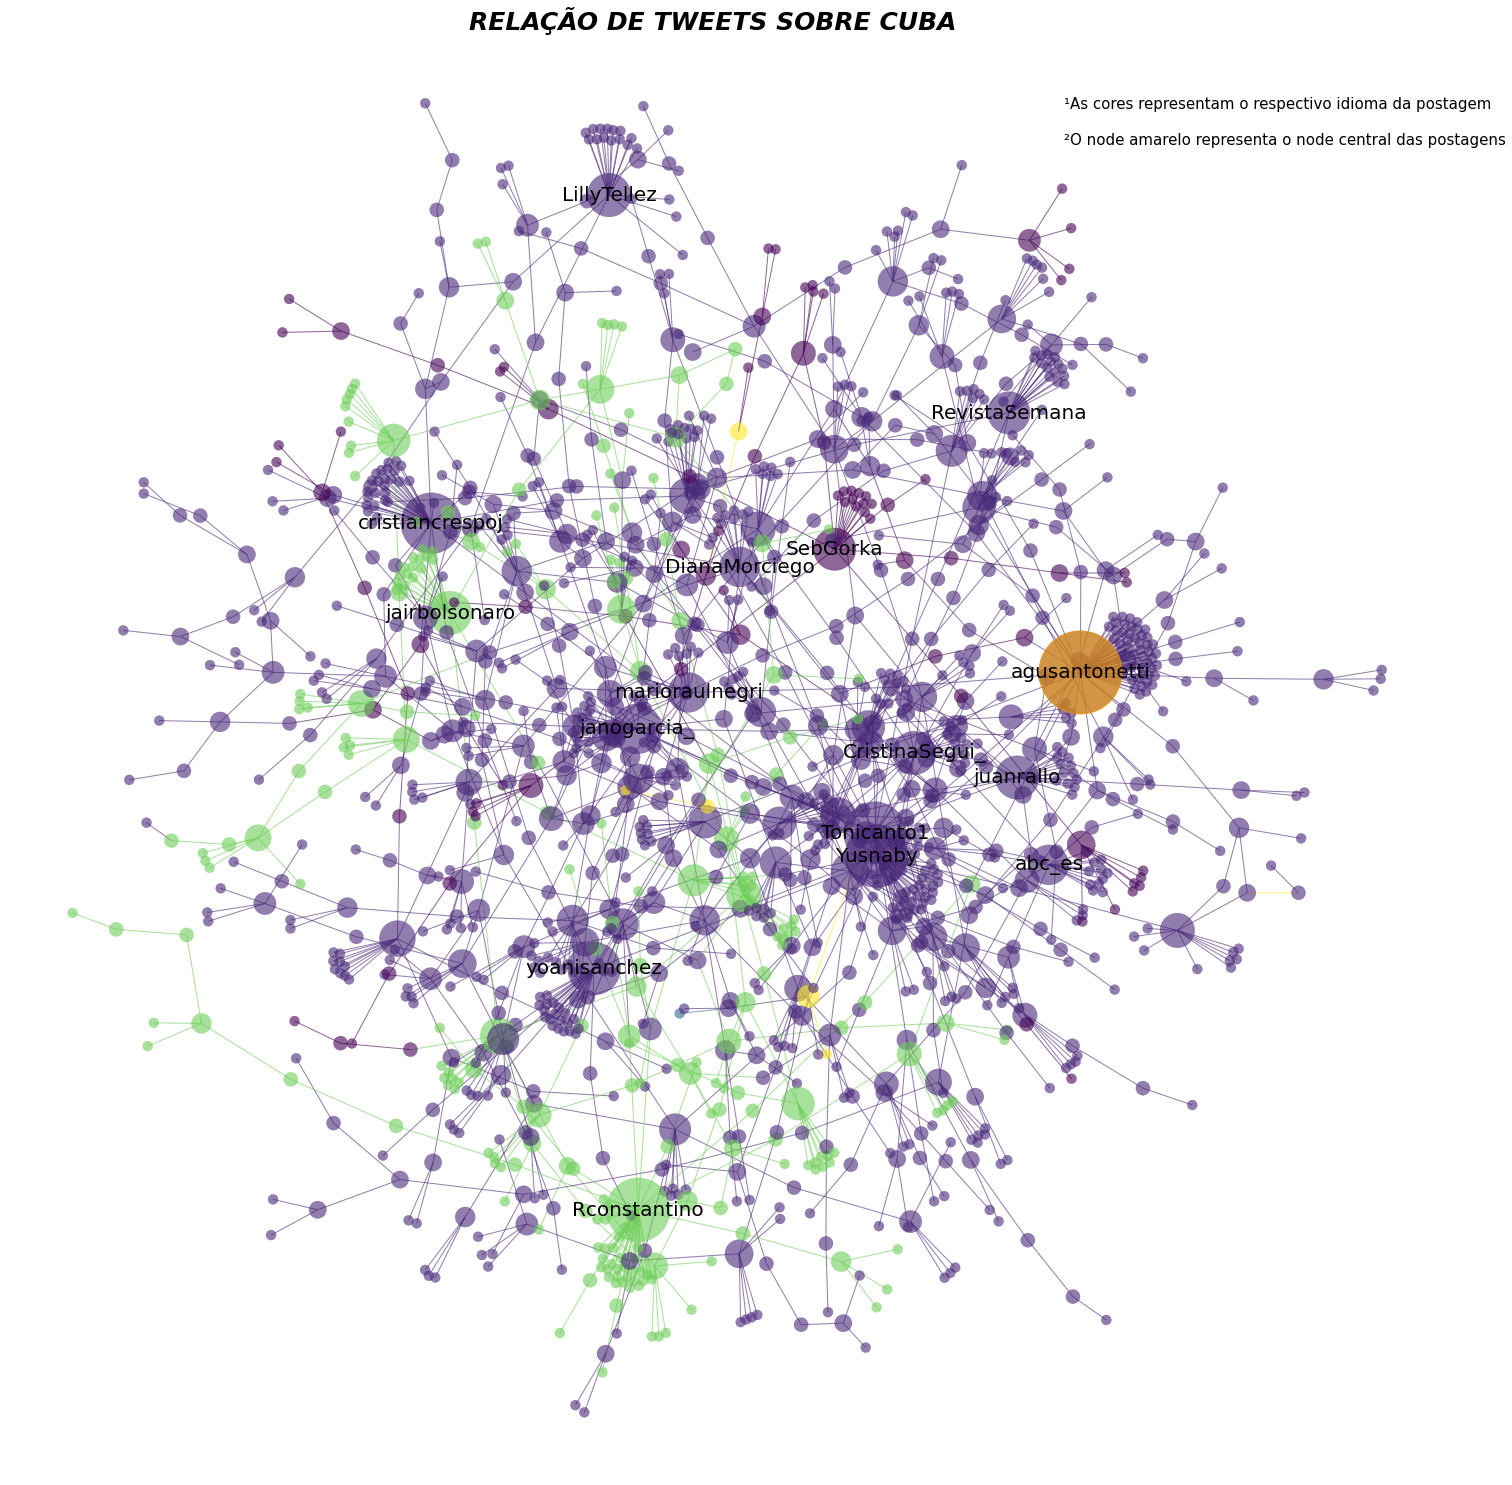

In [42]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=language2, edge_color=language, linewidths=0.3, node_size=[v * 100 for v in d.values()], alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=100*size_center_node, alpha=0.6, node_color=colors_central_nodes)
nx.draw_networkx_labels(largest_subgraph, pos=pos, labels=label, font_size=20, font_color='black')
plt.savefig('graphfinal.png')
plt.text(0.5,0.9,"¹As cores representam o respectivo idioma da postagem", size=15)
plt.text(0.5,0.85,"²O node amarelo representa o node central das postagens", size=15)
plt.text(-0.4,1.01,"RELAÇÃO DE TWEETS SOBRE CUBA", style='oblique', fontweight='bold', size=25)
plt.show()

## WordCloud

### Remoção das stopwords em  espanhol e em inglês, a partir de duas bases de stopwords que juntas formam abarcam um número maior de palavras

In [43]:
import re
from stop_words import get_stop_words
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
stop_words = list(get_stop_words('es', 'en'))
nltk_words = list(nltk.corpus.stopwords.words(['spanish', 'english']))
stop_words.extend(nltk_words)

### Criação de uma função de limpeza que remove acentos e outras pontuações

In [45]:
def limpeza_dados(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace("''","").replace(" no ", "").replace(" si ", "").replace("'", "").replace(".","").replace(";","").replace("-","").replace(":","").replace(")","").replace("@","").replace("rt ", "")
    palavras = [i for i in instancia.split() if not i in stop_words]
    return (" ".join(palavras))

In [46]:
dados_final['texto_processado'] = [limpeza_dados(i) for i in dados_final['text']]

### Contagem de palavras que mais aparecem

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(dados_final['texto_processado'])

In [49]:
word_count = pd.DataFrame(cv.get_feature_names(), columns=['word'])

word_count['count'] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending = False).reset_index(drop = True)

In [50]:
word_count.head(10)

,word,count
0,cuba,3606
1,em,289
2,dictadura,265
3,pueblo,259
4,soscuba,236
5,bloqueo,228
6,libertad,205
7,presidente,198
8,protestas,187
9,gobierno,180


In [51]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [52]:
texto_str = str(dados_final['texto_processado'].values)

In [53]:
texto_str

'[\'aduana_cuba #cuba #soscuba #11jcuba minint_cuba dispararon\'\n \'gordomonstruo__ llegaron compañeros venezolanos embajada cuba señores, grito "venezuela cuba, misma lucha" htt…\'\n \'afpespanol #últimahora cuba autoriza viajeros libre importación medicinas alimentos (oficial #afp\'\n ...\n \'anitaskywalker boludito alimentado leche almendras puré palta orgánica, soltas cuba da cuenta l…\'\n \'janislcani seguimos blanqueando emerito lleva residencias comunidad madrid hacen, diciendo que…\'\n \'panaclo vivaaaaa fidel, vivaaa cuba 🇨🇺 viva ser pobre austero ¿ves? *léase tono fresa 🍓 *\']'

In [54]:
texto_str = texto_str.replace("'", "").replace(" "" ", "").replace("#", "").replace(",", "").replace("\n", "").replace("(","").replace(")","").replace("[","").replace("]","")

In [55]:
texto_str

'aduana_cuba cuba soscuba 11jcuba minint_cuba dispararon gordomonstruo__ llegaron compañeros venezolanos embajada cuba señores grito "venezuela cuba misma lucha" htt… afpespanol últimahora cuba autoriza viajeros libre importación medicinas alimentos oficial afp ... anitaskywalker boludito alimentado leche almendras puré palta orgánica soltas cuba da cuenta l… janislcani seguimos blanqueando emerito lleva residencias comunidad madrid hacen diciendo que… panaclo vivaaaaa fidel vivaaa cuba 🇨🇺 viva ser pobre austero ¿ves? *léase tono fresa 🍓 *'

In [56]:
from wordcloud import WordCloud

In [57]:
wc = WordCloud(
               stopwords = stop_words,
               background_color="black",
               #relative_scaling=0,
              ).generate(texto_str)

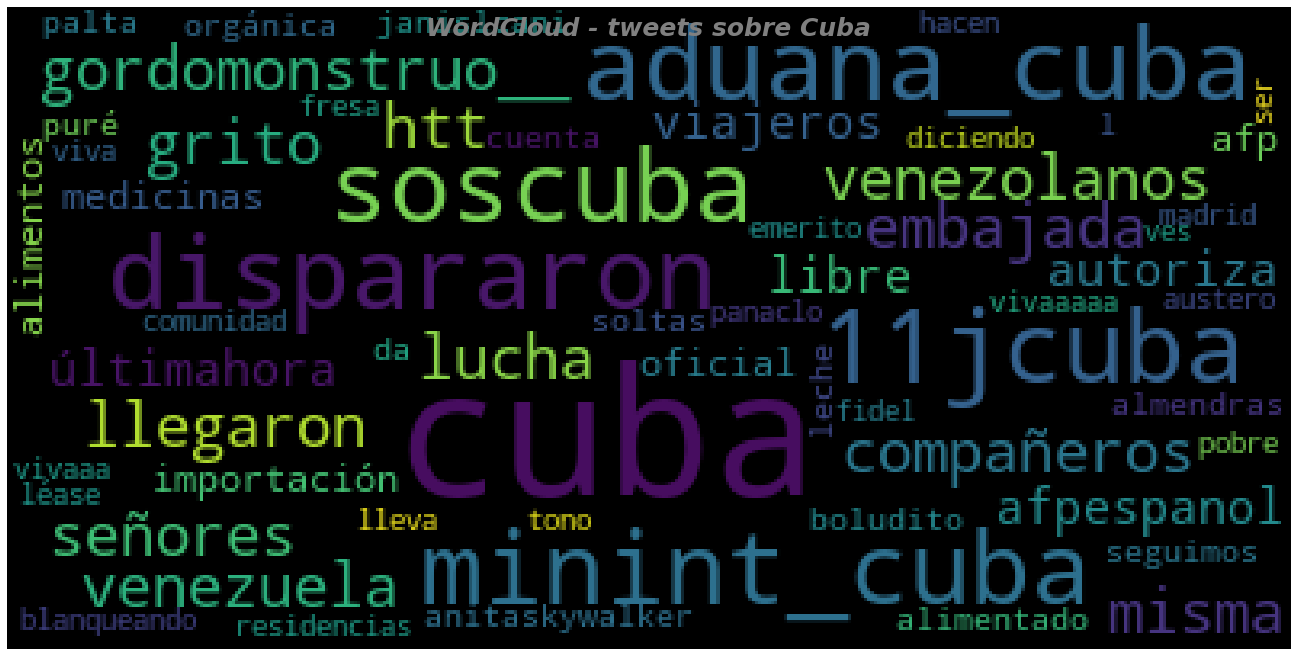

In [58]:
fig, ax = plt.subplots(figsize=(23,13))
ax.imshow(wc)
ax.set_axis_off()
plt.title("WordCloud - tweets sobre Cuba", ha='center', va='top', fontsize=25, color='grey', style='oblique', fontweight='bold', loc='center', y=1,  pad= -10)
plt.imshow(wc)